In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from IPython.display import Markdown,display
import gc
import time
from functools import partial
from os import path
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, NGram

import random
import numpy
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import auc_score
from apyori import apriori
from datetime import datetime
from itertools import combinations
from collections import Counter

plt.rcParams["figure.figsize"] = (20,10)
warnings.simplefilter('ignore')

/Users/manohar/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
def printmd(string):
    display(Markdown(string))

def get_unique_count(x):
    return len(np.unique(x))

def toReadable(v):
    value=round(v,2) if isinstance(v,float) else v
    if value<1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

### Reading Data

In [3]:
# Read the data
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

### Feature Selection

In [4]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)
order_products_all = pd.merge(order_products_all, products, on='product_id', how='left')
order_products_all = pd.merge(order_products_all, orders, on='order_id', how='left')
order_products_all = pd.merge(order_products_all, aisles, on='aisle_id', how='left')
order_products_all = pd.merge(order_products_all, departments, on='department_id', how='left')
order_products_all.head()

The order_products_all size is :  (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods


In [5]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, orders, on='order_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients,pantry


In [6]:
train_order_products = pd.merge(order_products_train, orders, on='order_id', how='left')
train_order_products = pd.merge(train_order_products, products, on='product_id', how='left')

train_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [7]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
order_products_train = pd.merge(order_products_train, products, on='product_id', how='left')
order_products_train = pd.merge(order_products_train, aisles, on='aisle_id', how='left')
order_products_train = pd.merge(order_products_train, departments, on='department_id', how='left')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [8]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [9]:
orders_apriori=orders.copy()

#### Taking a Small subset

In [10]:
transactions_df=order_products_prior[['order_id','product_id']][:10000]

In [11]:
# obtain number of order and products
n_orders=len(set(transactions_df.order_id))
n_products=len(set(transactions_df.product_id))
print(n_orders,n_products)

977 4511


- We have 977 orders and 4511 in the choosen subset

#### Calculating Product frequency

In [12]:
# obtain frequency of items and assign it to product_frequency
product_frequency=transactions_df.product_id.value_counts()/n_orders
min(product_frequency), max(product_frequency)

(0.0010235414534288639, 0.15967246673490276)

### Product_frequency vs number of times

Text(0, 0.5, 'number of times')

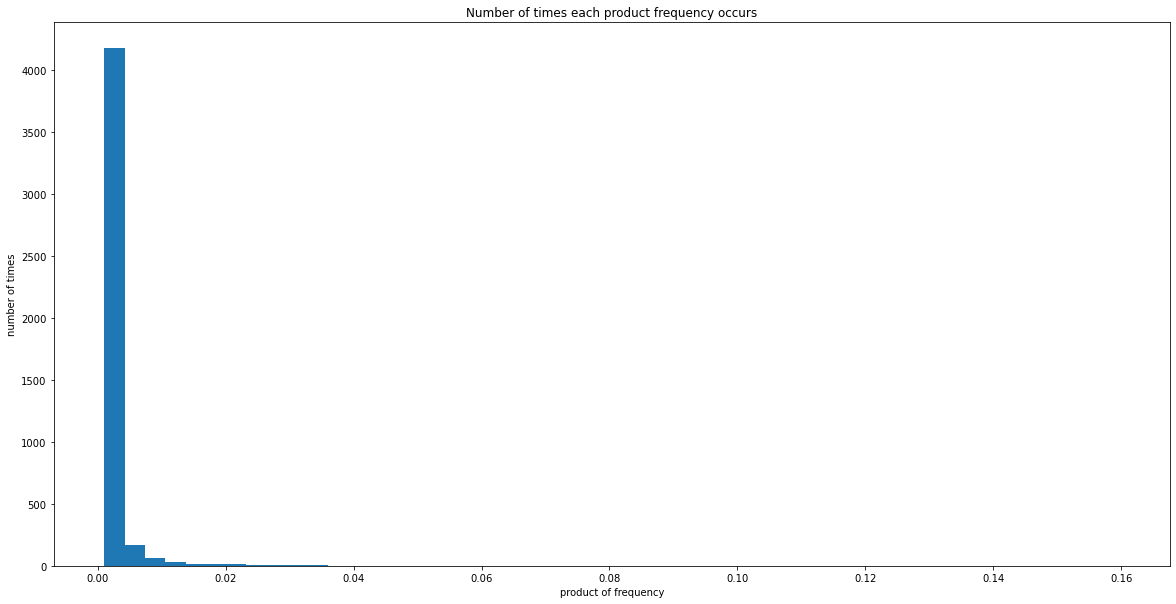

In [13]:
plt.hist(product_frequency,bins=50)
plt.title('Number of times each product frequency occurs')
plt.xlabel('product of frequency')
plt.ylabel('number of times')

In [14]:
# filter products by number of frequency with a minimum support of 0.01
min_support=0.01
products_apriori=product_frequency[product_frequency>=min_support]
print(products_apriori)

24852    0.159672
13176    0.121801
21137    0.074719
21903    0.071648
47209    0.069601
           ...   
43789    0.010235
22963    0.010235
35921    0.010235
41290    0.010235
9839     0.010235
Name: product_id, Length: 125, dtype: float64


#### Get a new transactions dataframe containing only these products

In [15]:
# after obtaining the new transaction, it is assigned to transactions_apriori
transactions_apriori=transactions_df[transactions_df.product_id.isin(products_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
9957      1019       24852
9958      1019       24838
9986      1020       41290
9995      1022       21903
9997      1022       30391

[2615 rows x 2 columns]


#### Plot data by number of times each order size

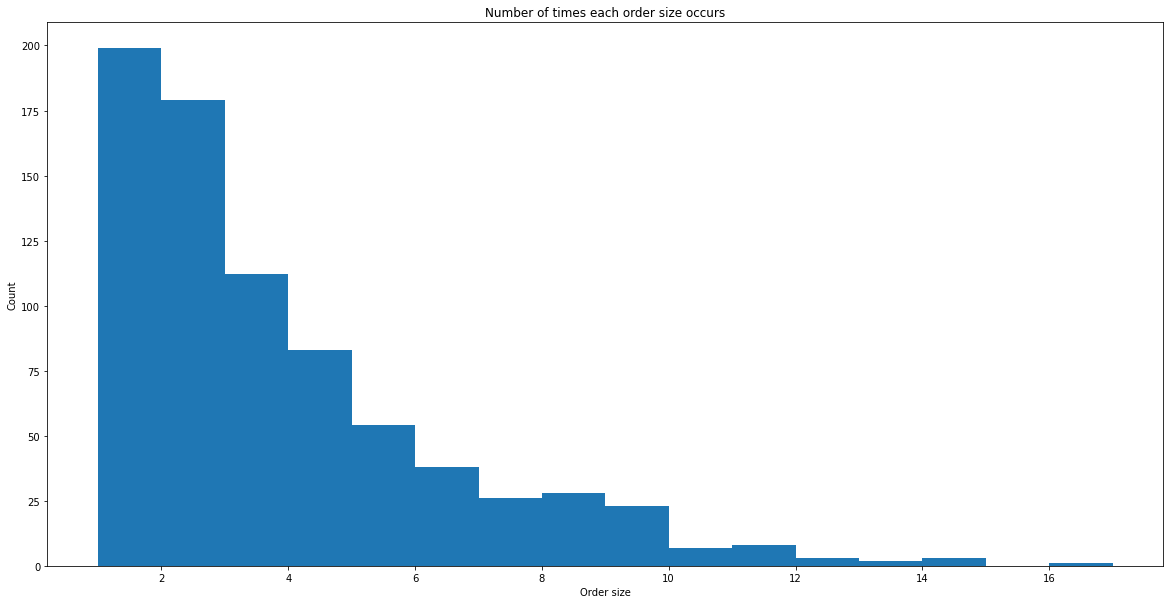

In [16]:
order_sizes=transactions_apriori.order_id.value_counts()
plt.hist(order_sizes,bins=max(order_sizes)-min(order_sizes));
plt.title('Number of times each order size occurs');
plt.xlabel('Order size')
plt.ylabel('Count')
plt.show()

- The above shows that maximum orders have 1 or 2 products, and we know that its difficult to make associtaion rules using only 1 product.
- If we take the value for minimum length as 4,then we cannot include the orders which have 2 or 3 products.
- So we will set the minimum length to 2.

#### set the minimum length equals to 2

In [17]:
min_length=2
orders_apriori=order_sizes[order_sizes>=min_length]
print(orders_apriori)

1002    17
251     14
431     14
493     14
426     13
        ..
421      2
790      2
792      2
423      2
499      2
Name: order_id, Length: 567, dtype: int64


In [18]:
transactions_apriori=transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
9955      1019       43295
9957      1019       24852
9958      1019       24838
9995      1022       21903
9997      1022       30391

[2416 rows x 2 columns]


In [19]:
'''
    Group purchases by order_id, followed by retrieving the order list that contains the variable product_id.
    This will allow to generate all possible combinations of each order by limiting it to 2.
'''

transactions_by_order=transactions_apriori.groupby('order_id')['product_id']
for order_id,order_list in transactions_by_order:
    product_combinations=combinations(order_list,2)
    if(order_id<5):
        print('Order_id:',order_id,'\nOrder_list: ',list(order_list))
        print('Product combinations:')
        print([i for i in product_combinations])
        print('\n')

Order_id: 2 
Order_list:  [33120, 28985, 17794]
Product combinations:
[(33120, 28985), (33120, 17794), (28985, 17794)]


Order_id: 3 
Order_list:  [24838, 21903, 46667]
Product combinations:
[(24838, 21903), (24838, 46667), (21903, 46667)]




- Order_id:2, this order contains 3 products,with these 3 products, we have 3 possible combinations

#### Concatenate all combinations from all orders, then count the number of occurences

In [20]:
def product_combinations(transactions_df,max_length=5):
    transactions_by_order=transactions_df.groupby('order_id')['product_id']
    max_length_reference=max_length
    
    # iterate through transactions by order for order_id and order_list
    for order_id,order_list in transactions_by_order:
        max_length=min(max_length_reference,len(order_list))
        order_list=sorted(order_list)
        
        # now we can make the product combinations by using the max_length
        for l in range(2,max_length+1):
            product_combinations=combinations(order_list,l)
            for combination in product_combinations:
                yield combination

#### Displaying the product combination for each iteration

In [21]:
combs=product_combinations(transactions_apriori)
next(iter(combs))

(17794, 28985)

- The above result is the first combination generated based on the `transactions_apriori` dataframe.

In [22]:
for _ in range(100):
    print(next(iter(combs)))

(17794, 33120)
(28985, 33120)
(17794, 28985, 33120)
(21903, 24838)
(21903, 46667)
(24838, 46667)
(21903, 24838, 46667)
(13176, 23909)
(13176, 27966)
(13176, 47209)
(23909, 27966)
(23909, 47209)
(27966, 47209)
(13176, 23909, 27966)
(13176, 23909, 47209)
(13176, 27966, 47209)
(23909, 27966, 47209)
(13176, 23909, 27966, 47209)
(432, 14992)
(432, 21405)
(432, 31506)
(14992, 21405)
(14992, 31506)
(21405, 31506)
(432, 14992, 21405)
(432, 14992, 31506)
(432, 21405, 31506)
(14992, 21405, 31506)
(432, 14992, 21405, 31506)
(4605, 14992)
(4605, 21137)
(4605, 24852)
(4605, 31717)
(4605, 47766)
(4605, 49235)
(14992, 21137)
(14992, 24852)
(14992, 31717)
(14992, 47766)
(14992, 49235)
(21137, 24852)
(21137, 31717)
(21137, 47766)
(21137, 49235)
(24852, 31717)
(24852, 47766)
(24852, 49235)
(31717, 47766)
(31717, 49235)
(47766, 49235)
(4605, 14992, 21137)
(4605, 14992, 24852)
(4605, 14992, 31717)
(4605, 14992, 47766)
(4605, 14992, 49235)
(4605, 21137, 24852)
(4605, 21137, 31717)
(4605, 21137, 47766)
(460

- from the above result we can say that different products have 2-4 combinations, as max_length is 5.

#### Counting all combination occurrences

In [23]:
# we will count the product combinations to find the frequency
combs=product_combinations(transactions_apriori)
counter=Counter(combs).items()
combinations_count=pd.Series([x[1] for x in counter],index=[x[0] for x in counter])
combinations_frequency=combinations_count/n_orders
print(combinations_frequency)

(17794, 28985)                        0.003071
(17794, 33120)                        0.002047
(28985, 33120)                        0.002047
(17794, 28985, 33120)                 0.001024
(21903, 24838)                        0.003071
                                        ...   
(5077, 41950, 43961, 47209)           0.001024
(21903, 41950, 43961, 47209)          0.001024
(5077, 21903, 41950, 43961, 47209)    0.001024
(24838, 43295)                        0.001024
(24838, 24852, 43295)                 0.001024
Length: 60633, dtype: float64


In [24]:
min(combinations_frequency),max(combinations_frequency)

(0.0010235414534288639, 0.02456499488229273)

In [25]:
## Now we filter even more the combinations through minimum support
# and minimum length 
combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]

#print the product combination
print(combinations_apriori, len(combinations_apriori))

(13176, 27966)    0.015353
(13176, 47209)    0.023541
(21137, 24852)    0.012282
(24852, 47766)    0.016377
(21903, 24852)    0.024565
(16797, 43352)    0.010235
(24852, 49683)    0.010235
(24852, 47626)    0.011259
(21903, 47209)    0.010235
(21137, 47209)    0.016377
(13176, 22935)    0.011259
(24852, 28204)    0.015353
(24852, 27845)    0.012282
(24852, 45066)    0.011259
(9076, 24852)     0.010235
(16797, 24852)    0.012282
(13176, 21137)    0.019447
dtype: float64 17


### Deriving the rules

In [26]:
A = []
B = []
AB = []
for c in combinations_apriori.index:
    c_length = len(c) 
    '''
        obtain all possible combinations from 1 to c length elements - 1
        this will allow A to get a new combination of at least 1 element
        and leaving array B to have a maximum of 2 elements
    '''
    for l in range(1, c_length):
        comb = combinations(c, l)
        for a in comb:
            AB.append(c)
            b = list(c)
            for e in a:
                b.remove(e)
            b = tuple(b)
            if len(a) == 1:
                a = a[0]
            A.append(a)
            if len(b) == 1:
                b = b[0]
            B.append(b)

apriori_df = pd.DataFrame({'A': A,
                           'B': B,
                           'AB': AB})
apriori_df.head()
'''
    get each element's support from the previously calculated supports
    by creating a dictionary which will contain all the elements
    with their respective supports
'''
support = {**{k: v for k, v in products_apriori.items()}, 
           **{k: v for k, v in combinations_frequency.items()}}

apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])

apriori_df.drop('AB', axis = 1, inplace = True)

apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A

apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B

'''
    Apply the last filter for minimum confidence and lift
'''

# filter the apriori dataframe by minimum confidence and minimum lift
min_confidence = 0.2
min_lift = 1.0
apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
apriori_df = apriori_df[apriori_df.lift >= min_lift]

# sort apriori dataframe by lift
apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)

### Converting the product_ids to product_names

In [27]:
# converts product id to the appropiate name for easier reading
def convert_product_id_to_name(product_ids):
    # return result if produt_ids is equal to int
    if type(product_ids) == int:
        return products_id_to_name[product_ids]
    
    # if it not equal to int then we go through product_ids
    # and return the names
    names = []
    for prod in product_ids:
        name = products_id_to_name[prod]
        names.append(name)
    names = tuple(names)
    return names

In [28]:
# get the names of each product id and populate it in the columns
# A and B in order to understand the data better

products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}
apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,Raspberries,Strawberries,0.026612,0.053224,0.010235,0.384615,7.226331
1,Organic Fuji Apple,Banana,0.029683,0.159672,0.015353,0.517241,3.239390
2,Organic Raspberries,Bag of Organic Bananas,0.039918,0.121801,0.015353,0.384615,3.157725
3,Organic Strawberries,Organic Hass Avocado,0.074719,0.069601,0.016377,0.219178,3.149073
4,Organic Hass Avocado,Organic Strawberries,0.069601,0.074719,0.016377,0.235294,3.149073
5,Blueberries,Banana,0.022518,0.159672,0.010235,0.454545,2.846737
6,Organic Hass Avocado,Bag of Organic Bananas,0.069601,0.121801,0.023541,0.338235,2.776940
7,Honeycrisp Apple,Banana,0.028659,0.159672,0.011259,0.392857,2.460394
8,Organic Whole Milk,Banana,0.031730,0.159672,0.012282,0.387097,2.424318
9,Cucumber Kirby,Banana,0.027636,0.159672,0.010235,0.370370,2.319563


In [29]:
# association_rules will return the apriori dataframe
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    #load data set to be able to calculate supports and combinations late on
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    # get order size and then filter it through the minimum length
    # this is done in order to get the product supports
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    # this function will combine products based on the apriori method
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        
        # Loop through transactions by order
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            
            # iteration needed to obtain the combination product from order_list
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                
                # loop thorugh product_combination to get each combination
                for combination in product_combinations:
                    yield combination
   
    # count combination frequency and filters the combination 
    # through minimum support and minimum length just like we have done it before
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    # implement similar coding used previously
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    # this function will convert the product id to
    # it's actual name for easier reading
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    # apply converted product id function to apriori dataframe
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    # return final dataframe
    return apriori_df

#### Testing the function on whole dataset with min_support=0.01

In [30]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.01)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated
Execution time:  0:06:04.335396


In [31]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042618,0.082358,0.010619,0.249174,3.025499
1,Organic Fuji Apple,Banana,0.027761,0.146826,0.010506,0.378441,2.577484
2,Organic Raspberries,Bag of Organic Bananas,0.042618,0.118028,0.012637,0.296508,2.512197
3,Organic Hass Avocado,Bag of Organic Bananas,0.066011,0.118028,0.019354,0.293199,2.484160
4,Organic Avocado,Banana,0.055057,0.146826,0.016620,0.301866,2.055949
5,Organic Strawberries,Bag of Organic Bananas,0.082358,0.118028,0.019337,0.234787,1.989259
6,Strawberries,Banana,0.044663,0.146826,0.012905,0.288936,1.967882
7,Large Lemon,Banana,0.048054,0.146826,0.012862,0.267663,1.822995
8,Organic Baby Spinach,Bag of Organic Bananas,0.075224,0.118028,0.015722,0.209007,1.770829
9,Organic Baby Spinach,Banana,0.075224,0.146826,0.015957,0.212133,1.444796


- With minimum support of 0.01, we can see that the strongest relationship is between organic raspberries and organic strawberries, 25% users who bought raspberries also bought strawberries.
- All other association rules with these criteria involve some produce and bananas.
- The largest confidence is 38% which is between fuji apple and banana, but the lift is not high enough, ranging 1.4-2.6
- It is also noteworthy that, even though the rules output combinations of the most commonly purchased products, their support is lower than 0.02. That means that all other combinations of two products will be present in less than 2% of all orders. Combinations of three or more will more much rarer.

#### Testing the function on whole dataset with min_support=0.005 and max_length=4

In [33]:
start=datetime.now()
rules=association_rules(order_products_all,min_support=0.005,max_length=4)
print('Execution time: ',datetime.now()-start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
37 rules were generated
Execution time:  0:33:55.321748


In [34]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Cilantro,Limes,0.021831,0.043830,0.005550,0.254237,5.800474
1,Organic Garlic,Organic Yellow Onion,0.034051,0.035180,0.006851,0.201192,5.718889
2,Organic Lemon,Organic Hass Avocado,0.027271,0.066011,0.006583,0.241389,3.656823
3,Organic Cucumber,Organic Hass Avocado,0.025404,0.066011,0.005465,0.215129,3.258999
4,Organic Raspberries,Organic Strawberries,0.042618,0.082358,0.010619,0.249174,3.025499
5,Organic Blueberries,Organic Strawberries,0.031388,0.082358,0.007479,0.238274,2.893150
6,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023328,0.118028,0.007273,0.311789,2.641663
7,Organic Fuji Apple,Banana,0.027761,0.146826,0.010506,0.378441,2.577484
8,Organic Raspberries,Bag of Organic Bananas,0.042618,0.118028,0.012637,0.296508,2.512197
9,Organic Cucumber,Organic Strawberries,0.025404,0.082358,0.005256,0.206894,2.512124


- We see some other produce combined with banana, as well as milk and banana. The are some lifts higher than 5, for cilantro and lime, and garlic and onion. The higher confidence, 38%, is that of fuji apple and banana.

#### Testing the function on whole dataset with min_support=0.002 and max_length=3

In [35]:
start=datetime.now()
rules=association_rules(order_products_all,min_support=0.002,max_length=3)
print('Execution time: ',datetime.now()-start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
218 rules were generated
Execution time:  0:09:30.868720


In [37]:
rules.head(10)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005966,0.005067,0.002225,0.372909,73.602482
1,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005067,0.005966,0.002225,0.439096,73.602482
2,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.005966,0.005648,0.002045,0.342851,60.702117
3,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005648,0.005966,0.002045,0.362136,60.702117
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.009225,0.006397,0.002859,0.309888,48.442450
5,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% with Strawberry Lowfat Greek Strained...,0.006397,0.009225,0.002859,0.446858,48.442450
6,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained...,0.006142,0.009225,0.002463,0.400983,43.469253
7,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009225,0.006142,0.002463,0.266993,43.469253
8,Organic Whole Strawberries,Frozen Organic Wild Blueberries,0.009760,0.009256,0.002096,0.214802,23.207780
9,Frozen Organic Wild Blueberries,Organic Whole Strawberries,0.009256,0.009760,0.002096,0.226510,23.207780


With a minimum support of 0.002, 211 rules were generated. I am inspecting only the first 10.

The strongest association (lift 73) is between blueberry and raspberry non-fat yoghurt, followed by other paired flavors of yoghurt (lift 43-61). The highest confidence (45%) is also revolving yoghurts. Next, there are paired berries and peppers, then flavored sparkling water. Following, I notice what seems to be ingredientes for guacamole.

#### Testing the function on whole dataset with min_support = 0.001 and max_length = 2

In [38]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.001, max_length = 2)
print('Execution time: ', datetime.now() - start)


Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
400 rules were generated
Execution time:  0:02:32.448485


In [39]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Acai & Mixed Berries Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.002714,0.005966,0.001224,0.450782,75.561227
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Acai & Mixed Berries Yogurt,0.005966,0.002714,0.001224,0.205090,75.561227
2,Lemon Sparkling Water,Grapefruit Sparkling Water,0.002975,0.004650,0.001040,0.349438,75.154066
3,Grapefruit Sparkling Water,Lemon Sparkling Water,0.004650,0.002975,0.001040,0.223615,75.154066
4,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005067,0.005966,0.002225,0.439096,73.602482
...,...,...,...,...,...,...,...
395,Organic Romaine,Banana,0.007410,0.146826,0.001512,0.204082,1.389958
396,Grated Parmesan,Banana,0.014026,0.146826,0.002862,0.204019,1.389529
397,Organic Granny Smith Apple,Banana,0.018265,0.146826,0.003695,0.202287,1.377739
398,Organic Grade A Free Range Large Brown Eggs,Banana,0.012496,0.146826,0.002515,0.201306,1.371053
